In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
from cartopy import crs as ccrs

from PIL import ImageColor
from matplotlib.colors import rgb2hex
from generativepy.color import Color
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, LineString
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

pd.set_option('display.max_colwidth', 25)
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.figsize']=(12, 6)

In [2]:
gdf = gpd.read_parquet('./gridData.geo.parquet')

world = gpd.read_file('/media/system/shapefiles/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.zip')
world = world.simplify(0.03)

In [3]:
cmap_BO = LinearSegmentedColormap.from_list("", ['#7983ab','#f3f1e4', '#8be2ae'])
cmap_HT = LinearSegmentedColormap.from_list("", ['#7983ab','#fef1e4', '#f36b28'])
cmap_WT = LinearSegmentedColormap.from_list("", ['#7983ab','#f3f1e4', '#800080'])

In [4]:
lines = []
for i in np.arange(-60, 61, 30):
    lines.append(LineString([Point(-180, i), Point(180, i)]))
lines1 = gpd.GeoDataFrame(pd.DataFrame(lines, columns=['geometry']))

for i in np.arange(-180, 181, 45):
    lines.append(LineString([Point(i, -90), Point(i, 90)]))
lines2 = gpd.GeoDataFrame(pd.DataFrame(lines, columns=['geometry']))

In [5]:
##https://stackoverflow.com/a/20528097

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)

    return newcmap

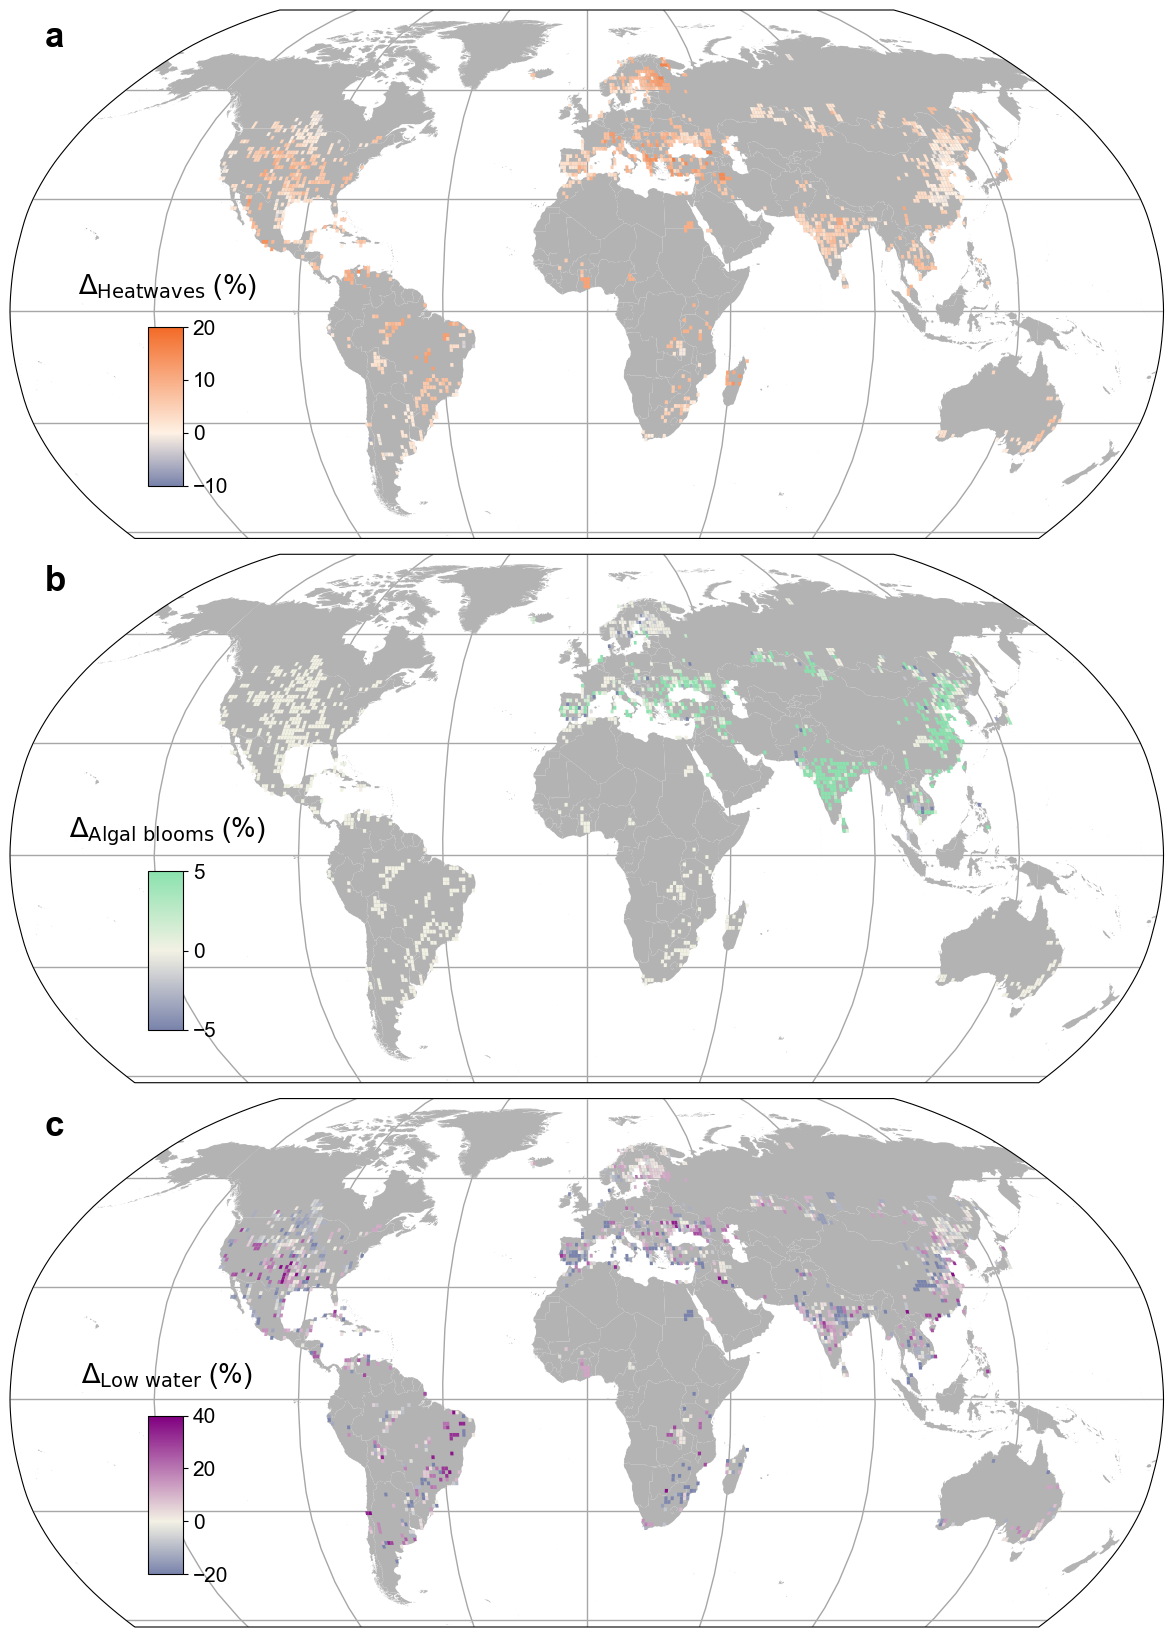

In [6]:
plt.rcParams.update({'font.size': 15})
args = [['delta_heat', cmap_HT, [-10,20]], 
        ['delta_BO', cmap_BO, [-5,5]], 
        ['delta_LowEx', cmap_WT, [-20,40]]]
labels = ['Δ$_\mathrm{Heatwaves}$ (%)', 'Δ$_\mathrm{Algal\ blooms}$ (%)', 'Δ$_\mathrm{Low\ water}$ (%)']

fig, axs = plt.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(20,21))
axs = axs.ravel()

letters = ['a','b','c']
for k in range(3):
    
    col, mcmap, [vmin, vmax] = args[k]
    mcmap1 = shiftedColorMap(mcmap, midpoint=np.abs(vmin)/(vmax-vmin))
    
    ##########################################################################################

    lines2.plot(ax=axs[k], color='#a7a7a7',lw=1, transform=ccrs.PlateCarree(), zorder=1)
        
    world.plot(ax=axs[k], transform=ccrs.PlateCarree(), facecolor='#b3b3b3', edgecolor='#b3b3b3', lw=0, zorder=2)

    cax = axs[k].inset_axes(bounds=[0.12, 0.1, 0.03, 0.3])
    gdf.plot(ax=axs[k], cax=cax, transform=ccrs.PlateCarree(), column=col, legend=True, cmap=mcmap1, lw=0, 
             marker='o', markersize=10, zorder=3, vmin=vmin, vmax=vmax)
    axs[k].set_ylim(-6525154.6651, 8625154.6651)

    axs[k].text(0.03, 0.93, letters[k], weight='bold', fontsize=25, transform=axs[k].transAxes)
    cax.text(0.55, 1.25, labels[k], ha='center', va='center', fontsize=20, transform=cax.transAxes)
    
plt.subplots_adjust(hspace=0.03)